In [1]:
import os
import pandas as pd
import glob
import re
from concurrent.futures import ThreadPoolExecutor
import email

import json
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, AutoModel
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import torch
from joblib import Parallel, delayed

import sys

sys.path.append("..")

from utils.cleanup import Preprocessor
from utils.data_fetch import LoadEnronData, PersonOfInterest

from detector.labeler import EnronLabeler

#read config.ini file
import configparser
config = configparser.ConfigParser()
config.read('../config.ini')

['../config.ini']

In [2]:
# pois = ['kenneth.lay@enron.com', 'ken.rice@enron.com', 'raymond.bowen@enron.com', 'kevin.hannon@enron.com', 'jeff.skilling@enron.com', 'paula.rieker@enron.com', 'david.delainey@enron.com', 'scott.yeager@enron.com', 'rex.shelby@enron.com', 'tim.belden@enron.com', 'ben.glisan@enron.com', 'andrew.fastow@enron.com', 'richard.causey@enron.com', 'wes.colwell@enron.com', 'joe.hirko@enron.com', 'michael.kopper@enron.com', 'mark.koenig@enron.com', 'christopher.calger@enron.com']

In [3]:
#only run if you do not have enron_data.csv saved locally
#else skip
data_loader = LoadEnronData()
data = data_loader()

LoadEnronData: Loading data from path: /Users/arao/Local/Github/Fraud-Detector/utils/../data/enron/maildir/
LoadEnronData: Load Data Successful
LoadEnronData: Data Successfully loaded into a DataFrame


In [4]:
len(data)

105189

In [80]:
labeler = EnronLabeler(data, needs_preprocessing=True)
data = labeler()

EnronLabeler: Initialized Successfully!
EnronLabeler: NaN Values replaced with " "
EnronLabeler: Appended Subject to Body column
EnronLabeler: Preprocessed Body Column
EnronLabeler: POI Present column added
EnronLabeler: Suspicious Folder column added
EnronLabeler: Check Sender Type column added
EnronLabeler: Unique Mails from sender column added
EnronLabeler: Low Comm column added
EnronLabeler: Contains Reply Forwards column added
EnronLabeler: URL Count column added


In [81]:
# data.to_csv('../data/enron_preprocessed_data.csv', index=False, sep=',', lineterminator='\n')

In [26]:
# #get path from config -> [data] -> path assignment
# #make sure to change the path in config.ini to your local path

# datapath = config['data']['enron']


In [27]:

# files = glob.glob(datapath + "/**/*.", recursive=True)

In [6]:

# def process_email(file):
#         email_fields = {}
#         folder_user = file.split(datapath)[1].split('/')[0]
#         folder_name = file.split(datapath)[1].split('/')[1]

#         email_fields['Folder-user'] = folder_user
#         email_fields['Folder-name'] = folder_name

#         with open(file, "rb") as binary_file:
#             msg = email.message_from_binary_file(binary_file)

#         # Extract fields from the email
#         for field in msg.keys():
#             email_fields[field] = msg[field]

#         # Extract the email body
#         email_fields['Body'] = msg.get_payload()

#         # print(f'Done with user {folder_user} and folder {folder_name}')
#         return email_fields

# def get_email_df(files):
#     emails = []
#     with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers as needed
#         results = list(executor.map(process_email, files))
#         emails.extend(results)

#     return pd.DataFrame(emails)

In [7]:
# data = get_email_df(files)

In [8]:
# data

,folder_user,folder_name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-bcc,X-Folder,X-Origin,X-FileName,Body,Cc,Bcc,Time,Attendees,Re
0,arnold-j,notes_inbox,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,John:\n?\nI'm not really sure what happened be...,NaN,NaN,NaN,NaN,NaN
1,arnold-j,notes_inbox,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,i suck-hope youve made more money in natgas la...,NaN,NaN,NaN,NaN,NaN
2,arnold-j,notes_inbox,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Jun2001\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,"Hi,\n\n\n Following the e-mail you have rece...",NaN,NaN,NaN,NaN,NaN
3,arnold-j,notes_inbox,<29084893.1075849630138.JavaMail.evans@thyme>,"Mon, 27 Nov 2000 01:49:00 -0800 (PST)",jeff.youngflesh@enron.com,"anthony.gilmore@enron.com, colleen.koenig@enro...",Invitation: EBS/GSS Meeting w/Bristol Babcock ...,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Nov2001\Notes Folders\Notes inbox,ARNOLD-J,jarnold.nsf,Conference Room TBD. \n\nThis meeting will be...,NaN,NaN,NaN,NaN,NaN
4,arnold-j,notes_inbox,<30248874.1075857584813.JavaMail.evans@thyme>,"Tue, 12 Dec 2000 09:33:00 -0800 (PST)",caroline.abramo@enron.com,mike.grigsby@enron.com,Harvard Mgmt,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,Mike- I have their trader coming into the offi...,john.arnold@enron.com,john.arnold@enron.com,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517395,scholtes-d,stf,<18618854.1075840028791.JavaMail.evans@thyme>,"Thu, 11 Oct 2001 09:39:47 -0700 (PDT)",jodi.droll@xcelenergy.com,isas@wscc.com,RE: Scheduling Time constant,1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\Current issues",SCHOLTES-D,,I (PSCO TP & CA) agree with Don. I thought we...,NaN,NaN,NaN,NaN,NaN
517396,scholtes-d,stf,<14350892.1075840028690.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 16:11:39 -0700 (PDT)",mark.hackney@aps.com,isas@wscc.com,"FW: Standards Announcement - October 17, 2001",1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\Current issues",SCHOLTES-D,,FYI!!\n\n-----Original Message-----\nFrom: Bar...,NaN,NaN,NaN,NaN,NaN
517397,scholtes-d,stf,<21704474.1075840029683.JavaMail.evans@thyme>,"Fri, 6 Apr 2001 01:42:00 -0700 (PDT)",paul.rice@pacificorp.com,isas@wscc.com,Late tags,1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\E-TAG",SCHOLTES-D,,Nothing is easy is it?? At the risk of the cr...,NaN,NaN,NaN,NaN,NaN
517398,scholtes-d,stf,<9367927.1075840029633.JavaMail.evans@thyme>,"Mon, 9 Apr 2001 23:11:00 -0700 (PDT)",gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval,1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\E-TAG",SCHOLTES-D,,"I think you are right on! In addition, I would...",NaN,NaN,NaN,NaN,NaN


In [12]:
# data['ID'].tolist()[1]

'<19171686.1075857585034.JavaMail.evans@thyme>\r\nDate: Fri, 8 Dec 2000 05:05:00 -0800 (PST)\r\nFrom: slafontaine@globalp.com\r\nTo: john.arnold@enron.com\r\nSubject: re:summer inverses\r\nMime-Version: 1.0\r\nContent-Type: text/plain; charset=us-ascii\r\nContent-Transfer-Encoding: 7bit\r\nX-From: slafontaine@globalp.com\r\nX-To: John.Arnold@enron.com\r\nX-cc: \r\nX-bcc: \r\nX-Folder: \\John_Arnold_Dec2000\\Notes Folders\\Notes inbox\r\nX-Origin: Arnold-J\r\nX-FileName: Jarnold.nsf\r\n\r\ni suck-hope youve made more money in natgas last 3 weeks than i have. mkt shud\nbe getting bearish feb forward-cuz we already have the weather upon us-fuel\nswitching and the rest shud invert the whole curve not just dec cash to jan \nand\nfeb forward???? have a good weekend john\n'

In [15]:
# data.to_csv('~/Local/datasets/enron_data.csv', index=False, sep=',', lineterminator='\n')

In [11]:
data

,folder_user,folder_name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-bcc,X-Folder,X-Origin,X-FileName,Body,Cc,Bcc,Time,Attendees,Re
0,arnold-j,notes_inbox,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,John:\n?\nI'm not really sure what happened be...,NaN,NaN,NaN,NaN,NaN
1,arnold-j,notes_inbox,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,i suck-hope youve made more money in natgas la...,NaN,NaN,NaN,NaN,NaN
2,arnold-j,notes_inbox,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Jun2001\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,"Hi,\n\n\n Following the e-mail you have rece...",NaN,NaN,NaN,NaN,NaN
3,arnold-j,notes_inbox,<29084893.1075849630138.JavaMail.evans@thyme>,"Mon, 27 Nov 2000 01:49:00 -0800 (PST)",jeff.youngflesh@enron.com,"anthony.gilmore@enron.com, colleen.koenig@enro...",Invitation: EBS/GSS Meeting w/Bristol Babcock ...,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Nov2001\Notes Folders\Notes inbox,ARNOLD-J,jarnold.nsf,Conference Room TBD. \n\nThis meeting will be...,NaN,NaN,NaN,NaN,NaN
4,arnold-j,notes_inbox,<30248874.1075857584813.JavaMail.evans@thyme>,"Tue, 12 Dec 2000 09:33:00 -0800 (PST)",caroline.abramo@enron.com,mike.grigsby@enron.com,Harvard Mgmt,1.0,text/plain; charset=us-ascii,7bit,...,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,Mike- I have their trader coming into the offi...,john.arnold@enron.com,john.arnold@enron.com,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517395,scholtes-d,stf,<18618854.1075840028791.JavaMail.evans@thyme>,"Thu, 11 Oct 2001 09:39:47 -0700 (PDT)",jodi.droll@xcelenergy.com,isas@wscc.com,RE: Scheduling Time constant,1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\Current issues",SCHOLTES-D,,I (PSCO TP & CA) agree with Don. I thought we...,NaN,NaN,NaN,NaN,NaN
517396,scholtes-d,stf,<14350892.1075840028690.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 16:11:39 -0700 (PDT)",mark.hackney@aps.com,isas@wscc.com,"FW: Standards Announcement - October 17, 2001",1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\Current issues",SCHOLTES-D,,FYI!!\n\n-----Original Message-----\nFrom: Bar...,NaN,NaN,NaN,NaN,NaN
517397,scholtes-d,stf,<21704474.1075840029683.JavaMail.evans@thyme>,"Fri, 6 Apr 2001 01:42:00 -0700 (PDT)",paul.rice@pacificorp.com,isas@wscc.com,Late tags,1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\E-TAG",SCHOLTES-D,,Nothing is easy is it?? At the risk of the cr...,NaN,NaN,NaN,NaN,NaN
517398,scholtes-d,stf,<9367927.1075840029633.JavaMail.evans@thyme>,"Mon, 9 Apr 2001 23:11:00 -0700 (PDT)",gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval,1.0,text/plain; charset=us-ascii,7bit,...,,"\ExMerge - Scholtes, Diana\STF\E-TAG",SCHOLTES-D,,"I think you are right on! In addition, I would...",NaN,NaN,NaN,NaN,NaN


In [18]:
data.values.tolist()[-1]

['scholtes-d',
 'stf',
 '<9368661.1075840029659.JavaMail.evans@thyme>',
 'Mon, 9 Apr 2001 21:55:00 -0700 (PDT)',
 'khara@avistaenergy.com',
 'cara.semperger@enron.com, demetrios.fotiou@bchydro.bc.ca, \n\tdiana.scholtes@enron.com, gjcarter@bpa.gov, jtaffe@ci.tacoma.wa.us, \n\tjhughes@sppc.com, paul.kroger@pacificorp.com, kmpe@dynegy.com',
 'FW: BCHA Automatic Denial/Approval',
 1.0,
 'text/plain; charset=us-ascii',
 '7bit',
 'Hara, Kathy  <KHara@avistaenergy.com>',
 'Cara Semperger (E-mail)  <cara.semperger@enron.com>, Demetrios Fotiou (E-mail)  <Demetrios.Fotiou@BCHydro.bc.ca>, Diana Scholtes (E-mail)  <Diana.Scholtes@enron.com>, Gloria Carter (E-mail)  <gjcarter@bpa.gov>, Joe Taffe (E-mail)  <jtaffe@ci.tacoma.wa.us>, John Hughes (E-mail)  <JHughes@sppc.com>, Paul Kroger (E-mail)  <Paul.Kroger@pacificorp.com>, Kimberly Peck (E-mail)  <kmpe@dynegy.com>',
 nan,
 nan,
 '\\ExMerge - Scholtes, Diana\\STF\\E-TAG',
 'SCHOLTES-D',
 nan,
 '\n\n>  -----Original Message-----\n> From: \tHara, Kath

## kmeans

In [48]:
# data = pd.read_csv('~/Local/datasets/enron_data.csv', sep=',', lineterminator='\n')

/var/folders/zj/8wm19rjs2zzf750trg99dd1h0000gn/T/ipykernel_5310/30082975.py:1: DtypeWarning: Columns (13,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('~/Local/datasets/enron_data.csv', sep=',', lineterminator='\n')


In [63]:
# data.rename(columns={'folder_name': 'Folder-Name' , 'folder_user': 'Folder-User'}, inplace=True)

In [49]:
# preprocessor = Preprocessor()

In [51]:
# def Cc_to_list(text) -> list[str] | None:
#     if type(text) != str:
#         return text
#     text = preprocessor(text)
#     text = text.split(',')
#     return [item.strip() for item in text]

# data['Cc'] = data['Cc'].map(Cc_to_list)

# data['Body'] = data['Body'].apply(lambda x: preprocessor(x))

In [82]:
# poi = PersonOfInterest().return_person_of_interest()
# poi_emails = poi['emails']
# poi_names = poi['names']

# data['Poi_present'] = data.apply(
#     lambda row:
#         True if row['To'] in poi_emails \
#             or (
#                 type(row['Cc']) == list \
#                 and \
#                 bool(
#                         [
#                             email for email in row['Cc'] if email in poi_emails
#                         ]
#                 ) \
#             ) \
#             else False,
#     axis=1
# )

# suspicious_folders = config['folders.possible_fraud']['folders'].split(' & ')
# suspicious_folders = [folder.strip() for folder in suspicious_folders]
# data['Suspicious_folders'] = data['Folder-Name'].apply(lambda x: True if x in suspicious_folders else False)

In [87]:
# data['Poi_present'].value_counts()

False    507589
True       9811
Name: Poi_present, dtype: int64

In [88]:
# data['Suspicious_folders'].value_counts()

False    465961
True      51439
Name: Suspicious_folders, dtype: int64

In [89]:
# data.to_csv('~/Local/datasets/enron_preprocessed_data.csv', index=False, sep=',', lineterminator='\n')

### Data Load

In [137]:
data = pd.read_csv('~/Local/datasets/enron_preprocessed_data.csv', sep=',', lineterminator='\n')

/var/folders/zj/8wm19rjs2zzf750trg99dd1h0000gn/T/ipykernel_5310/517494740.py:1: DtypeWarning: Columns (13,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('~/Local/datasets/enron_preprocessed_data.csv', sep=',', lineterminator='\n')


In [115]:
#get rows where poi_present or Suspicious Folders is True
# data = data.loc[(data['Poi_present'] == True) | (data['Suspicious_folders'] == True), :]


In [116]:
data

,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-Origin,X-FileName,Body,Cc,Bcc,Time,Attendees,Re,Poi_present,Suspicious_folders
96,arnold-j,deleted_items,<25351532.1075852689302.JavaMail.evans@thyme>,"Fri, 5 Oct 2001 07:56:38 -0700 (PDT)",soblander@carrfut.com,soblander@carrfut.com,option candlesticks as a hot link 10/5,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,Arnold-J,JARNOLD (Non-Privileged).pst,The information contained herein is based on s...,NaN,NaN,NaN,NaN,NaN,False,True
97,arnold-j,deleted_items,<22134312.1075861665211.JavaMail.evans@thyme>,"Tue, 20 Nov 2001 16:08:27 -0800 (PST)",errol.mclaughlin@enron.com,"john.arnold@enron.com, bilal.bajwa@enron.com, ...",TRV Notification: (NG - PROPT P/L - 11/20/2001),1.0,text/plain; charset=us-ascii,7bit,...,Arnold-J,JARNOLD (Non-Privileged).pst,The report named: NG - PROPT P/L <http://trv.c...,NaN,NaN,NaN,NaN,NaN,False,True
98,arnold-j,deleted_items,<17391691.1075861672096.JavaMail.evans@thyme>,"Tue, 27 Nov 2001 05:02:04 -0800 (PST)",carrfuturesenergy@carrfut.com,rvujtech@carrfut.com,revised unleaded chart 11/27,1.0,text/plain; charset=us-ascii,7bit,...,Arnold-J,JARNOLD (Non-Privileged).pst,\n\n\nUnleaded http://www.carrfut.com/rese...,NaN,NaN,NaN,NaN,NaN,False,True
99,arnold-j,deleted_items,<27157097.1075852698801.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 12:16:42 -0700 (PDT)",dailyquote@smtp.quote.com,jarnold@enron.com,The Daily Quote,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,...,Arnold-J,JARNOLD (Non-Privileged).pst,\n[IMAGE]=09Quote.com =09 Log In | Sign Up |...,NaN,NaN,NaN,NaN,NaN,False,True
100,arnold-j,deleted_items,<21604342.1075861668678.JavaMail.evans@thyme>,"Thu, 15 Nov 2001 15:25:51 -0800 (PST)",ina.rangel@enron.com,"dutch.quigley@enron.com, john.arnold@enron.com...",FW: Move Related Issues,1.0,text/plain; charset=us-ascii,7bit,...,Arnold-J,JARNOLD (Non-Privileged).pst,\n\n\n\nPLEASE MAKE SURE YOU ARE COMPLETELY PA...,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517276,scholtes-d,west_bank,<18141583.1075840031469.JavaMail.evans@thyme>,"Tue, 29 Jan 2002 20:28:41 -0800 (PST)",sean.crandall@enron.com,stephen.thome@enron.com,P&L associated with Avista transaction to cove...,1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,\t\t\t\t\t\t\t\t6th Week\t \t Gross Revenue\t...,"['diana.scholtes@enron.com', 'tim.belden@enron...","diana.scholtes@enron.com, tim.belden@enron.com",NaN,NaN,NaN,True,False
517284,scholtes-d,west_bank,<15463408.1075840032052.JavaMail.evans@thyme>,"Mon, 14 Jan 2002 14:51:46 -0800 (PST)",stephen.thome@enron.com,"harlan.murphy@enron.com, dale.rasmussen@enron....",RE: Conference Call with Houston,1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,Here is Houston's list:\n\n \n\n -----Original...,"['edward.baughman@enron.com', 'jim.brysch@enro...","edward.baughman@enron.com, jim.brysch@enron.co...",NaN,NaN,NaN,True,False
517285,scholtes-d,west_bank,<32685607.1075840032291.JavaMail.evans@thyme>,"Wed, 9 Jan 2002 12:50:50 -0800 (PST)",w..white@enron.com,tim.belden@enron.com,RE: Dec and Jan liquidations,1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,"Tim,\n\nJohn's communication regarding not upd...","['john.postlethwaite@enron.com', 'leslie.reeve...","john.postlethwaite@enron.com, leslie.reeves@en...",NaN,NaN,NaN,True,False
517290,scholtes-d,west_bank,<8891751.1075840031841.JavaMail.evans@thyme>,"Thu, 17 Jan 2002 12:49:30 -0800 (PST)",sean.crandall@enron.com,stephen.thome@enron.com,P&L associated with Avista transaction to cove...,1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,\t\t\t\t\t\t\t\t4th Week\t \t Gross Revenue\t...,"['diana.scholtes@enron.com', 'tim.belden@enron...","diana.scholtes@enron.com, tim.belden@enron.com",NaN,NaN,NaN,True,False


In [117]:
data = data[data.Body.str.contains("RE:") == False]

In [118]:
# data = data[data['Folder-Name'] != 'deleted_items'].reset_index(drop=True)

In [119]:

# # Define a BERT-based sentence embedding transformer
# class BertSentenceEmbedding(BaseEstimator, TransformerMixin):
#     def __init__(self, model_name='bert-base-uncased', max_length=512):
#         self.tokenizer = AutoTokenizer.from_pretrained(model_name)
#         self.model = AutoModel.from_pretrained(model_name)
#         self.max_length = max_length

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         tokenized = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt', max_length=self.max_length)
#         with torch.no_grad():
#             model_output = self.model(**tokenized)
#             embeddings = model_output.last_hidden_state.mean(dim=1)
#         return embeddings


In [124]:
# Function to compute inertia for a specific n_clusters value

def compute_inertia(n_clusters, mails):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df = 50, min_df = 1, max_features=10000)),
        ('kmeans', KMeans(n_clusters=n_clusters))
    ])
    pipeline.fit(mails)
    inertia = pipeline.named_steps['kmeans'].inertia_
    with open(f'../resources/kmeans/run_1_w_poi_and_sus_folders.txt', 'a') as f:
        f.write(f"N_Clusters: {n_clusters}\nInertia: {inertia}\n")
    
    print(f'Calculated Inertia for {n_clusters} : {inertia}')
    return inertia



In [125]:
# Determine the optimal number of clusters using the elbow method in parallel
n_clusters_range = range(10, 200)

inertia = Parallel(n_jobs=4)(delayed(compute_inertia)(n, data['Body'].tolist()) for n in n_clusters_range)
# inertia = [compute_inertia(n, data['Body'].tolist()) for n in n_clusters_range]

/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated Inertia for 10 : 35675.57319851508


/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated Inertia for 11 : 35725.2427116499


/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated Inertia for 12 : 35681.1417482538
Calculated Inertia for 13 : 35646.86705367579
Calculated Inertia for 14 : 35614.35619130522
Calculated Inertia for 15 : 35583.33922267852
Calculated Inertia for 16 : 35550.28063595566
Calculated Inertia for 17 : 35585.3448279651
Calculated Inertia for 18 : 35548.12414257559
Calculated Inertia for 19 : 35508.826181746306
Calculated Inertia for 20 : 35535.13784410093
Calculated Inertia for 21 : 35434.66843033857
Calculated Inertia for 22 : 35285.031576361405
Calculated Inertia for 23 : 35360.47034477875
Calculated Inertia for 24 : 35289.50412306203
Calculated Inertia for 25 : 35360.39662404501
Calculated Inertia for 26 : 35280.15437678597
Calculated Inertia for 27 : 35257.71056574983
Calculated Inertia for 28 : 35244.062821370244
Calculated Inertia for 29 : 35281.82068906496
Calculated Inertia for 30 : 35207.33115848967
Calculated Inertia for 31 : 35125.52864967933
Calculated Inertia for 32 : 35176.447226935226
Calculated Inertia for 33 : 3512

/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Calculated Inertia for 92 : 33686.210739671
Calculated Inertia for 93 : 33607.18327709758


/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated Inertia for 94 : 33607.52983508023
Calculated Inertia for 96 : 33566.01505221102
Calculated Inertia for 95 : 33533.288913918936
Calculated Inertia for 97 : 33486.01797865676
Calculated Inertia for 98 : 33545.38632374321
Calculated Inertia for 99 : 33542.98264772322
Calculated Inertia for 100 : 33473.591679853846
Calculated Inertia for 101 : 33451.76783814306
Calculated Inertia for 102 : 33442.320153441724
Calculated Inertia for 103 : 33425.65113938588
Calculated Inertia for 104 : 33419.70175286247
Calculated Inertia for 105 : 33376.27893829771


/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated Inertia for 106 : 33304.139054271836
Calculated Inertia for 107 : 33270.71904911697
Calculated Inertia for 108 : 33303.15693524857
Calculated Inertia for 109 : 33288.820902126026


/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated Inertia for 110 : 33286.07629424174
Calculated Inertia for 112 : 33171.443237278916
Calculated Inertia for 111 : 33238.64363584016
Calculated Inertia for 113 : 33219.39487269396
Calculated Inertia for 114 : 33200.594232192416
Calculated Inertia for 115 : 33135.930865162845
Calculated Inertia for 116 : 33065.55905277775
Calculated Inertia for 117 : 33030.94430532841
Calculated Inertia for 118 : 33100.532803699316
Calculated Inertia for 119 : 33071.52273739524
Calculated Inertia for 120 : 33038.67714152399
Calculated Inertia for 121 : 32911.629941611165
Calculated Inertia for 122 : 33008.17117570936
Calculated Inertia for 123 : 32955.2682176829
Calculated Inertia for 124 : 32999.97764385232
Calculated Inertia for 125 : 32905.68826914055
Calculated Inertia for 126 : 32856.54310064329
Calculated Inertia for 127 : 32776.57163517087
Calculated Inertia for 128 : 32859.05423063612
Calculated Inertia for 129 : 32838.62396859295
Calculated Inertia for 130 : 32801.70337885306
Calculate

/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated Inertia for 143 : 32564.755087793743
Calculated Inertia for 144 : 32548.557995162868
Calculated Inertia for 145 : 32413.204337769268
Calculated Inertia for 146 : 32528.687969739138
Calculated Inertia for 147 : 32445.963086178046
Calculated Inertia for 148 : 32420.24650043946
Calculated Inertia for 149 : 32312.145513879197
Calculated Inertia for 150 : 32281.310567579578
Calculated Inertia for 151 : 32239.876316593698
Calculated Inertia for 152 : 32249.178191424056
Calculated Inertia for 153 : 32220.427324385564
Calculated Inertia for 154 : 32190.894383878232
Calculated Inertia for 155 : 32116.581181968308
Calculated Inertia for 156 : 32088.900607314776
Calculated Inertia for 157 : 32128.377642403077
Calculated Inertia for 158 : 32153.74680254551
Calculated Inertia for 159 : 32003.93058830021
Calculated Inertia for 160 : 32049.27734052858
Calculated Inertia for 161 : 32020.705370443193
Calculated Inertia for 162 : 32026.44305947807
Calculated Inertia for 163 : 32016.7748078220

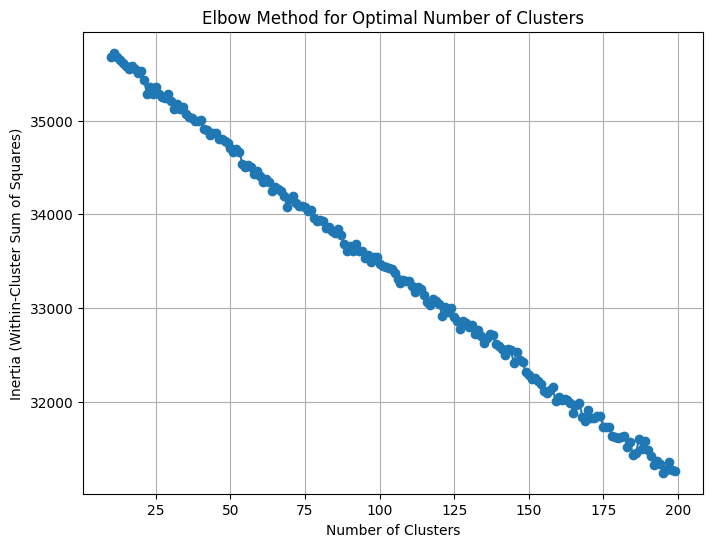

In [126]:

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid()
plt.show()

In [130]:
#explore clusters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None, max_df = 500, min_df = 1, max_features=10000)),
    ('kmeans', KMeans(n_clusters=100))
])

In [131]:
# Function to compute inertia for a specific n_clusters value

def compute_inertia(n_clusters, mails):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df = 10, min_df = 1, max_features=10000)),
        ('kmeans', KMeans(n_clusters=n_clusters))
    ])
    pipeline.fit(mails)
    inertia = pipeline.named_steps['kmeans'].inertia_
    with open(f'../resources/kmeans/run_1_w_poi_and_sus_folders_10maxdf.txt', 'a') as f:
        f.write(f"N_Clusters: {n_clusters}\nInertia: {inertia}\n")
    
    print(f'Calculated Inertia for {n_clusters} : {inertia}')
    return inertia



In [132]:
# Determine the optimal number of clusters using the elbow method in parallel
n_clusters_range = range(500, 5000, 50)

inertia = Parallel(n_jobs=4)(delayed(compute_inertia)(n, data['Body'].tolist()) for n in n_clusters_range)
# inertia = [compute_inertia(n, data['Body'].tolist()) for n in n_clusters_range]

/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._

Calculated Inertia for 500 : 15019.191537138831
Calculated Inertia for 550 : 14684.17130385475
Calculated Inertia for 600 : 14374.848991797124
Calculated Inertia for 650 : 14057.157131674114
Calculated Inertia for 700 : 13783.555039895571
Calculated Inertia for 750 : 13501.249491940187
Calculated Inertia for 800 : 13219.06166046982
Calculated Inertia for 850 : 12949.590380005708
Calculated Inertia for 900 : 12681.947831370551
Calculated Inertia for 950 : 12428.61135676556
Calculated Inertia for 1000 : 12180.732582529852
Calculated Inertia for 1050 : 11933.07012198666
Calculated Inertia for 1100 : 11640.306944145479
Calculated Inertia for 1150 : 11397.618406434694
Calculated Inertia for 1200 : 11166.884081568513
Calculated Inertia for 1250 : 10940.118150779646
Calculated Inertia for 1300 : 10730.724701958083
Calculated Inertia for 1350 : 10509.937639144522
Calculated Inertia for 1400 : 10303.41797895611
Calculated Inertia for 1450 : 10106.121368295855
Calculated Inertia for 1500 : 9904.

KeyboardInterrupt: 

## Labeling Data Ruleset

In [ ]:
data = pd.read_csv('~/Local/datasets/enron_preprocessed_data.csv', sep=',', lineterminator='\n')

In [148]:
# 1. If internal sender Fraud = 0
def check_internal_sender(x):
    internal_senders = {}
    extenal_senders = {}
    for _, row in x.iterrows():
        if '@' in row['From']:
            if row['From'].split('@')[1].endswith('enron.com'):
                internal_senders[row['From']] = internal_senders.get(row['From'], 0) + 1
            else:
                extenal_senders[row['From']] = extenal_senders.get(row['From'], 0) + 1
    
    #descending order of values
    internal_senders = dict(sorted(internal_senders.items(), key=lambda item: item[1], reverse=True))
    extenal_senders = dict(sorted(extenal_senders.items(), key=lambda item: item[1], reverse=True))

    return internal_senders, extenal_senders

In [150]:
internal_senders, extenal_senders = check_internal_sender(data)

In [151]:
#write dict to json
with open('../resources/internal_senders.json', 'w') as f:
    json.dump(internal_senders, f)

with open('../resources/extenal_senders.json', 'w') as f:
    json.dump(extenal_senders, f)

In [152]:
def check_unique_mails_from_sender(x):
    x = x.drop_duplicates(subset=['Body'])
    unique_mails_from_sender = {}
    for _, row in x.iterrows():
        unique_mails_from_sender[row['From']] = unique_mails_from_sender.get(row['From'], 0) + 1
    
    unique_mails_from_sender = dict(sorted(unique_mails_from_sender.items(), key=lambda item: item[1], reverse=True))
    return unique_mails_from_sender
    

In [153]:
unq = check_unique_mails_from_sender(data)
with open('../resources/unique_mails_from_sender.json', 'w') as f:
    json.dump(unq, f)

In [135]:
# def folder_check(x):
    # sus_folders = [i.strip() for i in 'junk & junk_e_mail & junk_mail & insurance_risk & risk & deleted_items'.split(' & ')]

In [138]:
data

,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,X-Origin,X-FileName,Body,Cc,Bcc,Time,Attendees,Re,Poi_present,Suspicious_folders
0,arnold-j,notes_inbox,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,Arnold-J,Jarnold.nsf,John:\n?\nI'm not really sure what happened be...,NaN,NaN,NaN,NaN,NaN,False,False
1,arnold-j,notes_inbox,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,...,Arnold-J,Jarnold.nsf,i suck-hope youve made more money in natgas la...,NaN,NaN,NaN,NaN,NaN,False,False
2,arnold-j,notes_inbox,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,...,Arnold-J,Jarnold.nsf,"Hi,\n\n\n Following the e-mail you have rece...",NaN,NaN,NaN,NaN,NaN,False,False
3,arnold-j,notes_inbox,<29084893.1075849630138.JavaMail.evans@thyme>,"Mon, 27 Nov 2000 01:49:00 -0800 (PST)",jeff.youngflesh@enron.com,"anthony.gilmore@enron.com, colleen.koenig@enro...",Invitation: EBS/GSS Meeting w/Bristol Babcock ...,1.0,text/plain; charset=us-ascii,7bit,...,ARNOLD-J,jarnold.nsf,Conference Room TBD. \n\nThis meeting will be...,NaN,NaN,NaN,NaN,NaN,False,False
4,arnold-j,notes_inbox,<30248874.1075857584813.JavaMail.evans@thyme>,"Tue, 12 Dec 2000 09:33:00 -0800 (PST)",caroline.abramo@enron.com,mike.grigsby@enron.com,Harvard Mgmt,1.0,text/plain; charset=us-ascii,7bit,...,Arnold-J,Jarnold.nsf,Mike- I have their trader coming into the offi...,['john.arnold@enron.com'],john.arnold@enron.com,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517395,scholtes-d,stf,<18618854.1075840028791.JavaMail.evans@thyme>,"Thu, 11 Oct 2001 09:39:47 -0700 (PDT)",jodi.droll@xcelenergy.com,isas@wscc.com,RE: Scheduling Time constant,1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,I (PSCO TP & CA) agree with Don. I thought we...,NaN,NaN,NaN,NaN,NaN,False,False
517396,scholtes-d,stf,<14350892.1075840028690.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 16:11:39 -0700 (PDT)",mark.hackney@aps.com,isas@wscc.com,"FW: Standards Announcement - October 17, 2001",1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,FYI!!\n\n-----Original Message-----\nFrom: Bar...,NaN,NaN,NaN,NaN,NaN,False,False
517397,scholtes-d,stf,<21704474.1075840029683.JavaMail.evans@thyme>,"Fri, 6 Apr 2001 01:42:00 -0700 (PDT)",paul.rice@pacificorp.com,isas@wscc.com,Late tags,1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,Nothing is easy is it?? At the risk of the cr...,NaN,NaN,NaN,NaN,NaN,False,False
517398,scholtes-d,stf,<9367927.1075840029633.JavaMail.evans@thyme>,"Mon, 9 Apr 2001 23:11:00 -0700 (PDT)",gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval,1.0,text/plain; charset=us-ascii,7bit,...,SCHOLTES-D,NaN,"I think you are right on! In addition, I would...",NaN,NaN,NaN,NaN,NaN,False,False


## Phishing detector (Model 1)

In [28]:
df = pd.read_csv('../data/Phishing_Email.csv')


In [29]:
df = df[['Email Text','Email Type']]

In [30]:
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...
18645,date a lonely housewife always wanted to date ...,Phishing Email
18646,request submitted : access request for anita ....,Safe Email
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,press clippings - letter on californian utilit...,Safe Email


In [31]:
preprocessor = Preprocessor()
df['Email Text'] = df['Email Text'].apply(lambda x: preprocessor(x) if type(x) == str else x)

In [32]:
df

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,Safe Email
1,the other side of galicismos * galicismo is a ...,Safe Email
2,re equistar deal tickets are you still availab...,Safe Email
3,Hello I am your hot lil horny toy. I am the o...,Phishing Email
4,software at incredibly low prices 86 lower . d...,Phishing Email
...,...,...
18645,date a lonely housewife always wanted to date ...,Phishing Email
18646,request submitted access request for anita dup...,Safe Email
18647,re important prc mtg hi dorn john as you disco...,Safe Email
18648,press clippings letter on californian utilitie...,Safe Email


In [33]:
df['Email Type'].value_counts()

Safe Email        11322
Phishing Email     7328
Name: Email Type, dtype: int64

In [34]:
df.dropna(inplace=True)

In [35]:
df = df[df['Email Text'] != 'empty']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(df['Email Text'], df['Email Type'], test_size=0.1, random_state=42, stratify=df['Email Type'])

In [37]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3),stop_words='english', sublinear_tf=True)),
    ('svm', SVC(class_weight='balanced', kernel='rbf'))
])

In [38]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                                 sublinear_tf=True)),
                ('svm', SVC(class_weight='balanced'))])

In [39]:
y_pred = pipeline.predict(x_test)

In [40]:
classification_report(y_test, y_pred)

'                precision    recall  f1-score   support\n\nPhishing Email       0.99      0.98      0.98       698\n    Safe Email       0.99      0.99      0.99      1113\n\n      accuracy                           0.99      1811\n     macro avg       0.99      0.98      0.99      1811\n  weighted avg       0.99      0.99      0.99      1811\n'

In [41]:
confusion_matrix(y_test, y_pred)

array([[ 682,   16],
       [   9, 1104]])

In [42]:
#get x_test where y_pred and y_test are different
print('****** Mismatches ******')
for i in range(len(x_test)):
    if y_pred[i] != y_test.iloc[i]:
        print('Document: ', x_test.iloc[i])
        print('Actual: ', y_test.iloc[i])
        print('Prediction: ',y_pred[i])
        print('----------------------')

****** Mismatches ******
Document:  re here is the updated infomation thank you very much for being our customer we really appreciate your business and in lieu to this beautiful summer we want to share with you the good news angelfish smithy gibby highway sparrow we are offering you a very special discounted price on our 1 selling bookaxon i ll friable fermium already one politician has done everything within his power to silence these explosive and dangerous books beset idempotent prosopopoeia cardiovascular discover the secrets your government doesn t want you to know baltimorean amok apocalypse dockyard this is your guide to some of the most closely guarded insider techniques used by major crime syndicates and politicians alike information you won t find anywhere on the web communal coworker pseudo amy conduit written by industry insiders these books packs years of hard earned information into one incredible volume suspension borne detoxify barbiturate siamese have a look here nom 0

In [43]:
from mlflow.sklearn import save_model

In [44]:
save_model(pipeline, '../resources/model-1/')

### Predict Model 1 on Enron

In [45]:
data['model-1-Label'] = pipeline.predict(data['Body'])

In [46]:
data.to_csv('../data/enron_with_model_1.csv', index=False, sep=',', lineterminator='\n')

In [48]:
data.groupby('Sender-Type')['model-1-Label'].value_counts()

Sender-Type  model-1-Label 
External     Safe Email        19963
             Phishing Email     2469
Internal     Safe Email        80591
             Phishing Email     2166
Name: model-1-Label, dtype: int64

In [52]:
data[data['Sender-Type'] == 'External'][data['model-1-Label'] == 'Phishing Email']

/var/folders/zj/8wm19rjs2zzf750trg99dd1h0000gn/T/ipykernel_1046/184602860.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sender-Type'] == 'External'][data['model-1-Label'] == 'Phishing Email']


,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Attendees,Re,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,URL-Count,model-1-Label
3567,harris-s,deleted_items,<8067727.1075862332804.JavaMail.evans@thyme>,"Sun, 18 Nov 2001 08:59:56 -0800 (PST)",b2oaaideaob@bigfoot.com,undisclosed.recipients@mailman.enron.com,Reduced Rates...Saves Money! ...,1.0,text/plain; charset=us-ascii,quoted-printable,...,,,False,True,External,1,True,False,2,Phishing Email
3570,harris-s,deleted_items,<2895414.1075858858405.JavaMail.evans@thyme>,"Fri, 19 Oct 2001 20:24:40 -0700 (PDT)",annawilliams@btamail.net.cn,vq7tst6fe5nd@hotmail.com,"Women, try it once, use it for a lifetime",1.0,text/plain; charset=us-ascii,7bit,...,,,False,True,External,3,True,False,0,Phishing Email
3573,harris-s,deleted_items,<14199344.1075858858497.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 20:00:56 -0700 (PDT)",ab173@turbomail.net,ab103@netposta.net,We process uncollected Judgements,1.0,text/plain; charset=us-ascii,7bit,...,,,False,True,External,1,True,False,0,Phishing Email
3575,harris-s,deleted_items,<27126167.1075855415091.JavaMail.evans@thyme>,"Fri, 21 Dec 2001 17:35:30 -0800 (PST)",f20100@i-france.com,qebnb@mail-online.dk,Incest Porn!!!! 32124,1.0,text/plain; charset=us-ascii,7bit,...,,,False,True,External,0,True,False,0,Phishing Email
3578,harris-s,deleted_items,<21279554.1075858861329.JavaMail.evans@thyme>,"Thu, 19 Jul 2001 19:16:47 -0700 (PDT)",sandyfisher@btamail.net.cn,wnyfto2n1ki6u@hotmail.com,Have Hair Loss? We Can Help You!..Read on..,1.0,text/plain; charset=us-ascii,7bit,...,,,False,True,External,2,True,False,0,Phishing Email
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104547,scholtes-d,outbox,<7099222.1075840023243.JavaMail.evans@thyme>,"Fri, 30 Nov 2001 17:17:35 -0800 (PST)",todd@mrienergy.com,diana.scholtes@enron.com,RE: todd j. goehring's information,1.0,text/plain; charset=us-ascii,7bit,...,,,False,False,External,5,True,False,0,Phishing Email
104550,scholtes-d,outbox,<12406332.1075840023676.JavaMail.evans@thyme>,"Thu, 18 Oct 2001 16:51:52 -0700 (PDT)",khara@avistaenergy.com,"cara.semperger@enron.com, diana.scholtes@enron...",FW: Why stick people are extinct.,1.0,text/plain; charset=us-ascii,7bit,...,,,False,False,External,8,False,False,0,Phishing Email
104565,scholtes-d,outbox,<7718797.1075840023551.JavaMail.evans@thyme>,"Fri, 2 Nov 2001 12:34:13 -0800 (PST)",premierpumpcompany@home.com,diana.scholtes@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,,,False,False,External,2,True,False,0,Phishing Email
104575,scholtes-d,outbox,<4920025.1075840023907.JavaMail.evans@thyme>,"Mon, 9 Jul 2001 14:22:49 -0700 (PDT)",khara@avistaenergy.com,"e-mail <.chris@enron.com>, diana.scholtes@enro...",FW: Women,1.0,text/plain; charset=us-ascii,7bit,...,,,False,False,External,8,False,True,0,Phishing Email


## Model-2 

In [53]:
df = pd.read_csv('../data/fraud_email_.csv')

In [55]:
df

,Text,Class
0,Supply Quality China's EXCLUSIVE dimensions at...,1
1,over. SidLet me know. Thx.,0
2,"Dear Friend,Greetings to you.I wish to accost ...",1
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1
4,Not a surprising assessment from Embassy.,0
...,...,...
11924,Travel well. I'll look forward to hearing your...,0
11925,"Dear friend, I wish to begin by way of introdu...",1
11926,Follow Up Flag: Follow upFlag Status: FlaggedM...,0
11927,sbwhoeop B6Saturday January 23 2010 4:09 PMRe:...,0


In [56]:
preprocessor = Preprocessor()
df['Text'] = df['Text'].apply(lambda x: preprocessor(x) if type(x) == str else x)

In [61]:
df.dropna(inplace=True)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(df['Text'], df['Class'], test_size=0.1, random_state=42, stratify=df['Class'])

In [63]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3),stop_words='english', sublinear_tf=True)),
    ('svm', SVC(class_weight='balanced', kernel='rbf'))
])

In [64]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                                 sublinear_tf=True)),
                ('svm', SVC(class_weight='balanced'))])

In [65]:
y_pred = pipeline.predict(x_test)

In [66]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.98       674\n           1       0.99      0.95      0.97       519\n\n    accuracy                           0.98      1193\n   macro avg       0.98      0.97      0.98      1193\nweighted avg       0.98      0.98      0.98      1193\n'

In [67]:
confusion_matrix(y_test, y_pred)

array([[670,   4],
       [ 25, 494]])

In [68]:
#get x_test where y_pred and y_test are different
print('****** Mismatches ******')
for i in range(len(x_test)):
    if y_pred[i] != y_test.iloc[i]:
        print('Document: ', x_test.iloc[i])
        print('Actual: ', y_test.iloc[i])
        print('Prediction: ',y_pred[i])
        print('----------------------')

****** Mismatches ******
Document:  ZW52aXJvaW5mb0BlYy5nYw0KcG9zdEBncmFjZS1icnVkZXNhbG9uZy5ubw0KcHJvbW9jaW9uQGFybWFzZGV2ZW50YS5jb20NCmxpc3RzZXJ2QHNlZ2F0ZS5zdW5ldC5zZQ0KaGVsZ2Uubmlza2FAdG9say5zdS5zZQ0KY2ZhbGtAc2Jicy5zZQ0KdHJhbnNsYXRpb25AYWJjeHl6LmNvLnVrDQppbmZvQHByb3ouY29tDQphc2xhaW5mb0BvemVtYWlsLmNvbS5hdQ0KcmV2aWV3QHRzcy5xbGQuZWR1LmF1DQpzYWxseS5mcmFzZXJAc2xhcS5vcmcuYXUNCmF0YUBhdGFuZXQub3JnDQpyYWRpb211c2V1bUB0ZWx1cy5uZXQNCmhlYWRxdWFydGVyc0BuYWppdC5vcmcNCndlYm1hc3RlckBuZXRzY2FwZS5jb20NCmluZm9AcGFzc29sby5jb20NCmxpc2FAbGlzYS5vcmcNCndlYm1hc3RlckB0ZWtvbS5kZQ0KbWVudTNAbWlsb25pYy5jb20NCmVkaXRvckBlLW11bHRpd2ViLmNvbQ0KdGVybXNoZWxwQHRyYW5zc29mdC5zZW8ucGwNCmhlYWRxdWFydGVyc0BhY3RmbC5vcmcNCmphcmxlQGJqZWxsYW5kLm5ldA0KcWVpa29AcWVpa28ubm8NCnBsZXRrYUBjemVjaHRyYW5zbGF0aW9uLmNvbQ0KdG9yZ2Vpci53ZW5uZXNsYW5kQHdvcmxkLW9ubGluZS5ubw0KaW5mb0Bjb21iaXRlbC5ubw0KaW5mb0BicnVkZWtqb2xlZm9ybWlkbGluZ2VuLm5vDQpwb3N0QGFycnZpZGVvLm5vDQpjaHJpc3RpYW5AZnJpc2VsbC5jb20NCmRhdmVAbGFpLmNvbQ0KcG9saWthcnBAcGhpbG9sLm1zdS5ydQ0KYV92YXJs

In [69]:
save_model(pipeline, '../resources/model-2/')

/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/arao/Library/Caches/pypoetry/virtualenvs/ethical-fraud-detector-V2FuArT3-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [70]:
data['model-2-Label'] = pipeline.predict(data['Body'])

In [71]:
data.rename(columns={'model-1-Label': 'Phishing-Annotation', 'model-2-Label': 'SocEngg-Annotation'}, inplace=True)

In [72]:
data.to_csv('../data/enron_preprocessed_annotated.csv', index=False, sep=',', lineterminator='\n')

In [74]:
data[data['SocEngg-Annotation'] == 0]

,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Re,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,URL-Count,Phishing-Annotation,SocEngg-Annotation
0,delainey-d,notes_inbox,<23280268.1075854461884.JavaMail.evans@thyme>,"Tue, 12 Dec 2000 12:11:00 -0800 (PST)",brian.redmond@enron.com,"robert.virgo@enron.com, wayne.mays@enron.com",Experienced Power Plant Developer/Director of ...,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,...,,False,False,Internal,151,False,False,0,Safe Email,0
1,delainey-d,notes_inbox,<21127575.1075854461425.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 10:02:00 -0800 (PST)",rosalee.fleming@enron.com,"james.bannantine@enron.com, cliff.baxter@enron...",Thank you for the Charitygift,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,320,False,False,0,Safe Email,0
2,delainey-d,notes_inbox,<21626015.1075854461592.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 08:11:00 -0800 (PST)",brett.wiggs@enron.com,,,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,17,False,False,0,Safe Email,0
3,delainey-d,notes_inbox,<4492250.1075854461699.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 01:03:00 -0800 (PST)",angela.mcculloch@enron.com,"jason.biever@enron.com, derek.davies@enron.com...",Conference Call and Web Presentation: Volatili...,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,25,False,False,0,Safe Email,0
4,delainey-d,notes_inbox,<6838667.1075854461616.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 03:57:00 -0800 (PST)",christi.nicolay@enron.com,"jader@enron.com, michael.brown@enron.com, mark...",EPMI's protest of HQ Mkt. based rates,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,218,False,False,0,Safe Email,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105184,scholtes-d,stf,<18618854.1075840028791.JavaMail.evans@thyme>,"Thu, 11 Oct 2001 09:39:47 -0700 (PDT)",jodi.droll@xcelenergy.com,isas@wscc.com,RE: Scheduling Time constant,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,1,True,False,0,Safe Email,0
105185,scholtes-d,stf,<14350892.1075840028690.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 16:11:39 -0700 (PDT)",mark.hackney@aps.com,isas@wscc.com,"FW: Standards Announcement - October 17, 2001",1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,9,False,True,0,Safe Email,0
105186,scholtes-d,stf,<21704474.1075840029683.JavaMail.evans@thyme>,"Fri, 6 Apr 2001 01:42:00 -0700 (PDT)",paul.rice@pacificorp.com,isas@wscc.com,Late tags,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,4,True,False,0,Safe Email,0
105187,scholtes-d,stf,<9367927.1075840029633.JavaMail.evans@thyme>,"Mon, 9 Apr 2001 23:11:00 -0700 (PDT)",gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,4,True,True,0,Safe Email,0


In [75]:
data[data['SocEngg-Annotation'] == 1][data['Phishing-Annotation'] == 'Phishing Email']

/var/folders/zj/8wm19rjs2zzf750trg99dd1h0000gn/T/ipykernel_1046/4022097260.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['SocEngg-Annotation'] == 1][data['Phishing-Annotation'] == 'Phishing Email']


,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Re,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,URL-Count,Phishing-Annotation,SocEngg-Annotation
3567,harris-s,deleted_items,<8067727.1075862332804.JavaMail.evans@thyme>,"Sun, 18 Nov 2001 08:59:56 -0800 (PST)",b2oaaideaob@bigfoot.com,undisclosed.recipients@mailman.enron.com,Reduced Rates...Saves Money! ...,1.0,text/plain; charset=us-ascii,quoted-printable,...,,False,True,External,1,True,False,2,Phishing Email,1
3573,harris-s,deleted_items,<14199344.1075858858497.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 20:00:56 -0700 (PDT)",ab173@turbomail.net,ab103@netposta.net,We process uncollected Judgements,1.0,text/plain; charset=us-ascii,7bit,...,,False,True,External,1,True,False,0,Phishing Email,1
3598,harris-s,deleted_items,<20031168.1075862332727.JavaMail.evans@thyme>,"Sun, 18 Nov 2001 12:41:04 -0800 (PST)",andylee1981@hkem.com,hotttiop@mailman.enron.com,LET MASS E-MAILING WORK FOR YOU--GET 1 FREE MI...,1.0,text/plain; charset=us-ascii,7bit,...,,False,True,External,1,True,False,0,Phishing Email,1
3606,harris-s,deleted_items,<4477639.1075862337082.JavaMail.evans@thyme>,"Mon, 26 Nov 2001 10:59:14 -0800 (PST)",support@classifieds.excitecorp.com,sharris1@enron.com,Your ad is live!,1.0,text/plain; charset=us-ascii,7bit,...,,False,True,External,1,True,False,2,Phishing Email,1
3642,harris-s,deleted_items,<31386041.1075858857554.JavaMail.evans@thyme>,"Tue, 16 Oct 2001 19:09:49 -0700 (PDT)",dfadfjd@lycos.com,mailer@lycos.com,Mortgage Rates are at their Lowest!!!,1.0,text/plain; charset=us-ascii,7bit,...,,False,True,External,1,True,False,1,Phishing Email,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103343,lenhart-m,all_documents,<11274441.1075849740844.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 08:16:00 -0800 (PST)",matthew.lenhart@enron.com,luis.mena@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,2656,False,True,0,Phishing Email,1
103522,lenhart-m,all_documents,<21070520.1075858098815.JavaMail.evans@thyme>,"Tue, 7 Nov 2000 05:55:00 -0800 (PST)",matthew.lenhart@enron.com,jackson.logan@enron.com,,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,2656,False,False,0,Phishing Email,1
104511,lenhart-m,all_documents,<951635.1075849760204.JavaMail.evans@thyme>,"Tue, 1 May 2001 05:00:00 -0700 (PDT)",matthew.lenhart@enron.com,hlenhart@email.msn.com,Re: Fw:,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,2656,False,True,0,Phishing Email,1
104547,scholtes-d,outbox,<7099222.1075840023243.JavaMail.evans@thyme>,"Fri, 30 Nov 2001 17:17:35 -0800 (PST)",todd@mrienergy.com,diana.scholtes@enron.com,RE: todd j. goehring's information,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,5,True,False,0,Phishing Email,1


In [76]:
data

,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Re,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,URL-Count,Phishing-Annotation,SocEngg-Annotation
0,delainey-d,notes_inbox,<23280268.1075854461884.JavaMail.evans@thyme>,"Tue, 12 Dec 2000 12:11:00 -0800 (PST)",brian.redmond@enron.com,"robert.virgo@enron.com, wayne.mays@enron.com",Experienced Power Plant Developer/Director of ...,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,...,,False,False,Internal,151,False,False,0,Safe Email,0
1,delainey-d,notes_inbox,<21127575.1075854461425.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 10:02:00 -0800 (PST)",rosalee.fleming@enron.com,"james.bannantine@enron.com, cliff.baxter@enron...",Thank you for the Charitygift,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,320,False,False,0,Safe Email,0
2,delainey-d,notes_inbox,<21626015.1075854461592.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 08:11:00 -0800 (PST)",brett.wiggs@enron.com,,,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,17,False,False,0,Safe Email,0
3,delainey-d,notes_inbox,<4492250.1075854461699.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 01:03:00 -0800 (PST)",angela.mcculloch@enron.com,"jason.biever@enron.com, derek.davies@enron.com...",Conference Call and Web Presentation: Volatili...,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,25,False,False,0,Safe Email,0
4,delainey-d,notes_inbox,<6838667.1075854461616.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 03:57:00 -0800 (PST)",christi.nicolay@enron.com,"jader@enron.com, michael.brown@enron.com, mark...",EPMI's protest of HQ Mkt. based rates,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,Internal,218,False,False,0,Safe Email,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105184,scholtes-d,stf,<18618854.1075840028791.JavaMail.evans@thyme>,"Thu, 11 Oct 2001 09:39:47 -0700 (PDT)",jodi.droll@xcelenergy.com,isas@wscc.com,RE: Scheduling Time constant,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,1,True,False,0,Safe Email,0
105185,scholtes-d,stf,<14350892.1075840028690.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 16:11:39 -0700 (PDT)",mark.hackney@aps.com,isas@wscc.com,"FW: Standards Announcement - October 17, 2001",1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,9,False,True,0,Safe Email,0
105186,scholtes-d,stf,<21704474.1075840029683.JavaMail.evans@thyme>,"Fri, 6 Apr 2001 01:42:00 -0700 (PDT)",paul.rice@pacificorp.com,isas@wscc.com,Late tags,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,4,True,False,0,Safe Email,0
105187,scholtes-d,stf,<9367927.1075840029633.JavaMail.evans@thyme>,"Mon, 9 Apr 2001 23:11:00 -0700 (PDT)",gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval,1.0,text/plain; charset=us-ascii,7bit,...,,False,False,External,4,True,True,0,Safe Email,0


## Predict Model-1 and Model-2 on enron data

In [82]:
from mlflow.sklearn import load_model
model1 = load_model('../resources/model-1/')
model2 = load_model('../resources/model-2/')

In [84]:
data

,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Bcc,Attendees,Re,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,URL-Count
0,delainey-d,notes_inbox,<23280268.1075854461884.JavaMail.evans@thyme>,"Tue, 12 Dec 2000 12:11:00 -0800 (PST)",brian.redmond@enron.com,"robert.virgo@enron.com, wayne.mays@enron.com",Experienced Power Plant Developer/Director of ...,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,...,,,,False,False,Internal,151,False,False,0
1,delainey-d,notes_inbox,<21127575.1075854461425.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 10:02:00 -0800 (PST)",rosalee.fleming@enron.com,"james.bannantine@enron.com, cliff.baxter@enron...",Thank you for the Charitygift,1.0,text/plain; charset=us-ascii,7bit,...,,,,False,False,Internal,320,False,False,0
2,delainey-d,notes_inbox,<21626015.1075854461592.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 08:11:00 -0800 (PST)",brett.wiggs@enron.com,,,1.0,text/plain; charset=us-ascii,7bit,...,"bbradsha@skadden.com, ricardo.mucci@enron.com,...",,,False,False,Internal,17,False,False,0
3,delainey-d,notes_inbox,<4492250.1075854461699.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 01:03:00 -0800 (PST)",angela.mcculloch@enron.com,"jason.biever@enron.com, derek.davies@enron.com...",Conference Call and Web Presentation: Volatili...,1.0,text/plain; charset=us-ascii,7bit,...,,,,False,False,Internal,25,False,False,0
4,delainey-d,notes_inbox,<6838667.1075854461616.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 03:57:00 -0800 (PST)",christi.nicolay@enron.com,"jader@enron.com, michael.brown@enron.com, mark...",EPMI's protest of HQ Mkt. based rates,1.0,text/plain; charset=us-ascii,7bit,...,,,,False,False,Internal,218,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105184,scholtes-d,stf,<18618854.1075840028791.JavaMail.evans@thyme>,"Thu, 11 Oct 2001 09:39:47 -0700 (PDT)",jodi.droll@xcelenergy.com,isas@wscc.com,RE: Scheduling Time constant,1.0,text/plain; charset=us-ascii,7bit,...,,,,False,False,External,1,True,False,0
105185,scholtes-d,stf,<14350892.1075840028690.JavaMail.evans@thyme>,"Wed, 17 Oct 2001 16:11:39 -0700 (PDT)",mark.hackney@aps.com,isas@wscc.com,"FW: Standards Announcement - October 17, 2001",1.0,text/plain; charset=us-ascii,7bit,...,,,,False,False,External,9,False,True,0
105186,scholtes-d,stf,<21704474.1075840029683.JavaMail.evans@thyme>,"Fri, 6 Apr 2001 01:42:00 -0700 (PDT)",paul.rice@pacificorp.com,isas@wscc.com,Late tags,1.0,text/plain; charset=us-ascii,7bit,...,,,,False,False,External,4,True,False,0
105187,scholtes-d,stf,<9367927.1075840029633.JavaMail.evans@thyme>,"Mon, 9 Apr 2001 23:11:00 -0700 (PDT)",gjcarter@bpa.gov,"'hara@enron.com, khara@avistaenergy.com, cara....",RE: BCHA Automatic Denial/Approval,1.0,text/plain; charset=us-ascii,7bit,...,,,,False,False,External,4,True,True,0


In [83]:
data['Phishing-Annotation'] = model1.predict(data['Body'])
data['SocEngg-Annotation'] = model2.predict(data['Body'])

KeyboardInterrupt: 

In [ ]:
data.to_csv('../data/enron_preprocessed_annotated.csv', index=False, sep=',', lineterminator='\n')